# Tokenize Text

In [1]:
import pandas as pd
import cache_magic
from tqdm import tqdm

%cache magic is now registered in ipython


In [2]:
rumors_df = pd.read_csv('/Users/sean/g0v/rumors-db/opendata/articles.csv')
rumors_df.head(2)

id references  \
0  AV00_5WVyCdS-nWhucGR       LINE   
1  AV0090iuyCdS-nWhucGO       LINE   

                                        userIdsha256  tags  \
0  6d3008ecf79c7c949f018f609e7b083c5d0b9ce98e0a33...   NaN   
1  f194f6cc94c30094677c23bf095b7b29d9d14ca000139f...   NaN   

   normalArticleReplyCount            appId  \
0                      1.0  RUMORS_LINE_BOT   
1                      1.0  RUMORS_LINE_BOT   

                                                text  hyperlinks  \
0  中華民國的軍人對美國還有利用價值，所以老美出手警告蔡小英：\n\n    公教退撫條例日前已...         NaN   
1  這是一個真實的故事，加州一位女士在一家肉類加工廠工作。有一天，當她完成所有工作安排，走進冷庫...         NaN   

                  createdAt                 updatedAt  \
0  2017-07-12T04:12:31.508Z  2017-07-12T04:12:31.508Z   
1  2017-07-12T04:03:27.533Z  2017-07-12T04:03:27.533Z   

            lastRequestedAt  
0  2017-07-12T04:12:31.519Z  
1  2017-07-12T04:03:27.543Z

In [3]:
%cache rumors_text = rumors_df['text'].tolist()

loading cached value for variable 'rumors_text'. Time since pickling  10 days, 20:38:58.918155


In [4]:
def init_analyzer():
    from pyhanlp import JClass
    CRFLexicalAnalyzer = JClass("com.hankcs.hanlp.model.crf.CRFLexicalAnalyzer")
    analyzer = CRFLexicalAnalyzer()
    
    stopwords = JClass("com.hankcs.hanlp.dictionary.stopword.CoreStopWordDictionary")
    return analyzer, stopwords

In [5]:
import re
def tokenize_text(text):
    tokenized = analyzer.seg(re.sub('\n|\r', '', text))
    stopwords.apply(tokenized)
    return [token.word for token in tokenized]

In [6]:
def process_text():
    %cache tokenized_text = [tokenize_text(text) for text in tqdm(rumors_text)]
    %cache processed_text = [' '.join(text) + '\n' for text in tqdm(tokenized_text)]
    return tokenized_text, processed_text

In [7]:
from pathlib import Path
tokenized_text_file = Path('../data/processed/tokenized-stopwords.txt')
if not tokenized_text_file.exists():
    analyzer, stopwords = init_analyzer()
    
    tokenizaed_text, processed_text = process_text()
    with tokenized_text_file.open('w') as output:
        output.writelines(processed_text)
else:
    with tokenized_text_file.open('r') as input:
        tokenized_text = [line.rstrip().split(' ') for line in input.readlines()]


# fastText training

In [10]:
from pathlib import Path
model_file = Path('../models/rumors-fasttext.bin')
if model_file.exists():
    from fastText import load_model
    model = load_model(str(model_file))
else:
    from fastText import train_unsupervised
    model = train_unsupervised(input=str(tokenized_text_file))
    model.save_model(str(model_file))

AttributeError: '_FastText' object has no attribute 'save'

# HDBSCAN

In [12]:
vectors = [model.get_sentence_vector(text.rstrip()) for text in processed_text]

In [13]:
from sklearn.manifold import TSNE
%cache projection = TSNE().fit_transform(vectors)

creating new value for variable 'projection'


In [14]:
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

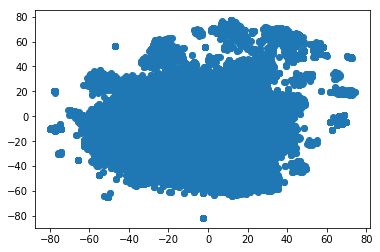

In [15]:
plt.scatter(*projection.T)

In [16]:
clusterer = hdbscan.HDBSCAN(prediction_data=True).fit(np.asarray(vectors).astype(np.float64))
np.unique(clusterer.labels_, return_counts=True)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120]),
 array([12081,    36,    12,     5,    20,     9,    10,     5,    12,
            8,   559,     5,     8,     6,     6,     8,     9,    15,
           12,     5,    16,     9,     6,     9,     9,    10,    24,
           45,    45,     7,     6,     5,     5,     5,    12,     7,
           14,     7,   

In [41]:
def plot(clusterer):
    color_palette = sns.color_palette('Paired', max(clusterer.labels_) + 1)
    
    cluster_colors = [color_palette[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in clusterer.labels_]
    cluster_member_colors = [sns.desaturate(x, p) for x, p in
                             zip(cluster_colors, clusterer.probabilities_)]
    plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

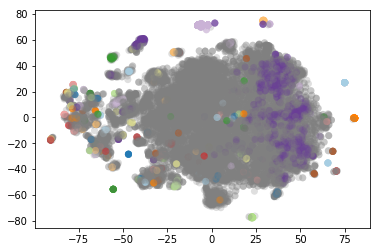

In [42]:
plot(clusterer)

In [43]:
from scipy import stats
stats.describe(clusterer.labels_)

DescribeResult(nobs=15588, minmax=(-1, 118), mean=15.374198101103413, variance=1386.8135178338528, skewness=2.0928005831950003, kurtosis=2.6683743480089372)

In [49]:
np.unique(clusterer_2.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([12538,    36,    35,   566,   135,    45,   481,    45,    50,
          119,  1495,    43]))

# Soft Clustering

/usr/local/lib/python3.6/site-packages/hdbscan/prediction.py:546: RuntimeWarning: invalid value encountered in double_scalars
  clusterer.prediction_data_.cluster_tree)


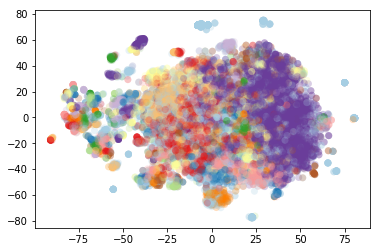

In [58]:
def plot_soft(clusterer):
    soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
    color_palette = sns.color_palette('Paired', len(clusterer.labels_))
    cluster_colors = [color_palette[np.argmax(x)]
                      for x in soft_clusters]
    plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

plot_soft(clusterer)

In [59]:
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
soft_clustered = [np.argmax(x) for x in soft_clusters]
np.unique(soft_clustered, return_counts=True)

/usr/local/lib/python3.6/site-packages/hdbscan/prediction.py:546: RuntimeWarning: invalid value encountered in double_scalars
  clusterer.prediction_data_.cluster_tree)


(array([  0,   2,   4,   5,   6,   7,  10,  11,  12,  13,  14,  15,  16,
         17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  30,
         31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
         44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
         97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
        110, 111, 112, 113, 114, 115, 116, 117, 118]),
 array([3271,    9,   37,   20,   21,   12,   20,   26,   16,    9,    1,
          17,   16,   62,   33,    2,   13,   11,   30,    9,   18,   10,
           9,   27,    4,   10,   13,    1,  110,   35,   61,   38,   29,
          28,   68,   37,   13,   54,    5,   46,   26,   20,   18,   23,
          36,   54,   21,   21,   56,   20,   48,   24,   25,   2

In [119]:
from operator import itemgetter
def check_cluster(i, limit=5):
#     soft_clustered = np.asarray(soft_clustered)
    indices = np.where(soft_clustered == i)


    if len(indices[0]) > 0:
        return itemgetter(*list(indices[0])[:limit])(processed_text)
    return []

for i in range(118):
    print('cluster ' + str(i))
    for text in check_cluster(i, 10):
        print(re.sub('\n|\r','',text) + '\n')

cluster 0
「 薑黃 」 不 是 人人 可 吃 ！ 「 三類人 」 誤 吃 當 心脹氣 、 暈眩 、 胃痙 攣http://ezp 9.com / p969 23.a sp

飲用 冰凍 過 的 金門 高粱 酒能 有效 對抗 癌症 ， 高粱 酒萃 取 物 的 治療 只 會 破壞 惡性 腫瘤 細胞 而 不 影響 健康 的 細胞 ； 另外 因為 喝 下去 的 冰凍 高粱 酒會 變成 鹼性 水 ， 每天 飲用 對 人體 有益

浙江 義烏 到 倫敦 的 鐵路 元旦 直達 痛車 ， 桃機 到 台北 捷運蓋 了 20年 還 沒 通車 ！ 當 您 看 完 這個 影片 ， 就 知道 台灣 實在 可憐 https : / / www.facebook.com/tvbsfb/videos/101540631300 45933 /

新疆 火車 在 雪 地 疾馳 而 過 -破雪 而 行- 實在 太 壯觀 了 ： http://m p.weixin.q q.com/s/jt0 ZPK 2g4cmCH-Ty 3 kv kVQ

名 : 白玉 蓮霧 ， 越南 品種 ， 在 宜蘭 種植 ， 已經 量產 ， 一 斤 120 左右

早安 ， 我們 完成 人生 的 一半 路程 ， 都 近 退休 年齡 ， 投資 上 都 要 謹慎 你 貪人家 的 利息 ， 別人 談 你 的 本金 。 一般 利息 超過 8% 年利率 以上 都 要 謹慎 評估 。 。 下則 新聞  參考億 圓 富 吸金 逾 90億 　 檢調 全台 大 搜索  http://m.a ppledaily.com.tw/realtimenews/article/new/20161213/1011323 / ? utm_source=Line&utm_medium=M Web_Share&utm_campaign=http% 3A% 2F% 2F www.a ppledaily.com.tw% 2Frealtimenews% 2Farticle% 2Fnew% 2 F 20161213% 2F 1011323% 2 F

蔡英文 前往 中 壢仁海宮 發 紅包 ， 很 多媒體 宣稱 綿延 三 公里 人潮 ， 但 事實 是  ～ 現場 不 到 百 人 ， 現場 直播 有 影片 有 真 像   !

陳建榮 ， 中正 理工學院 29 期 第一

# LDA

In [8]:
from gensim import corpora, models, similarities
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [9]:
%cache dictionary = corpora.Dictionary(tokenized_text)

%cache corpus= [dictionary.doc2bow(text) for text in tokenized_text]

loading cached value for variable 'dictionary'. Time since pickling  10 days, 20:40:30.234341
loading cached value for variable 'corpus'. Time since pickling  10 days, 20:40:29.371185


## LDF TF

In [12]:
%time lda = models.LdaMulticore(corpus, id2word=dictionary, num_topics=100, workers=3)

/usr/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


CPU times: user 23.7 s, sys: 13.2 s, total: 36.8 s
Wall time: 37.7 s


In [14]:
lda.show_topics()

[(0,
  '0.122*"" + 0.020*"，" + 0.016*"的" + 0.014*"," + 0.014*"。" + 0.013*"ོ༵" + 0.012*"靠" + 0.012*"the" + 0.008*"！" + 0.008*"to"'),
 (8,
  '0.018*"免費" + 0.018*"/" + 0.016*"去" + 0.014*":" + 0.012*"，" + 0.010*"主題" + 0.009*"https" + 0.009*"。" + 0.008*"" + 0.008*"的"'),
 (92,
  '0.049*"，" + 0.028*"的" + 0.020*"" + 0.018*"。" + 0.013*"是" + 0.010*"、" + 0.008*"有" + 0.006*"」" + 0.006*"「" + 0.006*"！"'),
 (17,
  '0.085*"，" + 0.044*"的" + 0.027*"。" + 0.017*"是" + 0.014*"" + 0.012*"、" + 0.012*"不" + 0.010*"有" + 0.009*"在" + 0.008*"了"'),
 (69,
  '0.060*"，" + 0.023*"的" + 0.019*"。" + 0.018*"" + 0.011*"是" + 0.011*"「" + 0.009*"」" + 0.007*"我" + 0.006*"了" + 0.006*"！"'),
 (1,
  '0.089*"，" + 0.047*"的" + 0.018*"。" + 0.014*"、" + 0.014*"是" + 0.011*"" + 0.008*"」" + 0.007*"了" + 0.007*"在" + 0.006*"「"'),
 (39,
  '0.025*"，" + 0.019*"！" + 0.018*"的" + 0.017*"!" + 0.014*"(" + 0.012*")" + 0.011*"/" + 0.007*"。" + 0.007*"" + 0.006*","'),
 (18,
  '0.029*"/" + 0.018*"ོ༵" + 0.017*"靠" + 0.016*"！" + 0.011*":" + 0.010*"肝病" + 0.009*"

In [16]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

/usr/local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17    -0.186251 -0.065078       1        1  29.769459
1     -0.165232 -0.069227       2        1   7.358717
75    -0.153785  0.232315       3        1   5.451008
21    -0.118162  0.105725       4        1   5.037173
10    -0.170989 -0.072917       5        1   4.955359
11    -0.129391 -0.004257       6        1   3.191430
52    -0.139102 -0.057355       7        1   2.986163
95    -0.136577 -0.013662       8        1   2.873054
94    -0.130970  0.059872       9        1   2.804829
47    -0.121838 -0.052259      10        1   2.080714
42    -0.131443  0.163076      11        1   2.055152
73    -0.124800  0.023019      12        1   1.827125
41    -0.039526 -0.068345      13        1   1.347175
2     -0.108608 -0.031992      14        1   1.289790
7     -0.106849  0.030944      15        1   1.176174
84    -0.108908 -0.061732      16        1   1.018285
36    -0.029445 -0.069635      17        1   1.014804
69    -0.052074 -0.036367      18        1   0.983647
45    -0.051088 -0.024243      19        1   0.951902
34    -0.069937  0.119723      20        1   0.919194
46     0.036433  0.062551      21        1   0.907298
76    -0.100384 -0.025345      22        1   0.896070
85    -0.104283  0.080835      23        1   0.868552
81    -0.112629 -0.045475      24        1   0.807283
61    -0.101450 -0.027906      25        1   0.764448
0     -0.036628  0.120231      26        1   0.661412
93    -0.090962 -0.025734      27        1   0.660183
4     -0.047983  0.076463      28        1   0.638488
40    -0.039760 -0.000128      29        1   0.624580
87     0.049421  0.017199      30        1   0.583640
...         ...       ...     ...      ...        ...
58    -0.010070 -0.012110      71        1   0.118729
33    -0.000778 -0.055691      72        1   0.116096
5      0.212619  0.030990      73        1   0.115933
22     0.076718  0.123782      74        1   0.108890
28     0.037069 -0.032999      75        1   0.106355
29     0.000086 -0.038487      76        1   0.106166
66     0.046262 -0.039849      77        1   0.105723
55     0.103848 -0.019597      78        1   0.099570
97     0.071625  0.000940      79        1   0.096019
89    -0.015007 -0.017357      80        1   0.090204
48     0.008073 -0.005506      81        1   0.090146
18     0.156195  0.016071      82        1   0.089391
32     0.042045 -0.015258      83        1   0.087432
23     0.008213 -0.009617      84        1   0.086776
26     0.077492 -0.008000      85        1   0.077504
49     0.159575  0.022035      86        1   0.075536
91     0.013482 -0.061288      87        1   0.074999
67     0.053151 -0.036778      88        1   0.072765
99     0.034770 -0.065214      89        1   0.070934
77     0.115231  0.008626      90        1   0.070834
83     0.134304 -0.019892      91        1   0.061983
88     0.132074 -0.019787      92        1   0.060430
44     0.127384 -0.010129      93        1   0.057245
72     0.089271 -0.035507      94        1   0.056966
65     0.016728 -0.009627      95        1   0.050336
90     0.049207 -0.001662      96        1   0.045052
86     0.088652 -0.044128      97        1   0.042984
3      0.257710 -0.007306      98        1   0.040620
6      0.126000 -0.031991      99        1   0.039471
24     0.231287  0.000235     100        1   0.035094

[100 rows x 5 columns], topic_info=       Category           Freq                   Term          Total  loglift  \
term                                                                            
0       Default  126309.000000                         126309.000000  30.0000   
275     Default  115902.000000                      ，  115902.000000  29.0000   
201     Default   61743.000000                      的   61743.000000  28.0000   
27      Default   36602.000000                      。   36602.000000  27.0000   
297     Default    9801.000000               

## LDA TFIDF

In [10]:
tfidf = models.TfidfModel(corpus, dictionary=dictionary)
corpus_tfidf = tfidf[corpus]

### 1 iteration

In [11]:
%time lda_tfidf = models.LdaMulticore(corpus_tfidf, id2word=dictionary,iterations=1,num_topics=100, workers=3)

/usr/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


CPU times: user 18.6 s, sys: 9.27 s, total: 27.9 s
Wall time: 27.9 s


In [12]:
lda_tfidf.show_topics()

[(61,
  '0.003*"下方" + 0.003*"全家" + 0.002*"鼻子" + 0.002*"心情" + 0.002*"喉嚨" + 0.002*"剋星" + 0.002*"感謝" + 0.002*"https" + 0.002*"篇" + 0.001*"發行"'),
 (78,
  '0.003*"10月" + 0.003*"圖片" + 0.002*"a" + 0.002*"赴" + 0.002*"愈" + 0.002*"資金" + 0.002*"喝" + 0.002*"釣魚" + 0.002*"集體" + 0.002*"早安"'),
 (80,
  '0.005*"兌換" + 0.003*"時代" + 0.002*"Facebook" + 0.002*"喝" + 0.002*"翹班" + 0.002*"澎湖馬公基地軍紀大崩壞" + 0.002*"軍官" + 0.002*"集體" + 0.002*"u" + 0.002*"聲色"'),
 (84,
  '0.004*"加油" + 0.003*"小朋友" + 0.002*"蹲" + 0.002*"包" + 0.001*"試" + 0.001*"聖誕" + 0.001*"因素" + 0.001*"大杯" + 0.001*"肌肉" + 0.001*"全都"'),
 (7,
  '0.003*"▼" + 0.003*"工廠" + 0.003*"電影" + 0.003*"操作" + 0.002*"酒" + 0.002*"  " + 0.002*"公益" + 0.002*"澎湖馬公基地軍紀大崩壞" + 0.002*"場所" + 0.002*"赴"'),
 (95,
  '0.003*"星巴克" + 0.003*"真" + 0.003*"假" + 0.002*"玩" + 0.002*"台灣" + 0.002*" " + 0.002*"太陽" + 0.001*"機票" + 0.001*"人權" + 0.001*"搶購"'),
 (26,
  '0.003*"  " + 0.002*"退撫" + 0.002*"癡呆症" + 0.002*"酵素" + 0.002*"卡通" + 0.001*"電腦" + 0.001*"https" + 0.001*"認真" + 0.001*"掌控" + 0.001*"基金"'),
 (22

In [13]:
pyLDAvis.gensim.prepare(lda_tfidf, corpus_tfidf, dictionary)

/usr/local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
55    -0.071369  0.060875       1        1  2.228444
68    -0.027006  0.010423       2        1  1.682097
14     0.012242  0.032174       3        1  1.556943
83    -0.017336  0.013560       4        1  1.553151
53    -0.043758 -0.040031       5        1  1.528665
34    -0.010643 -0.000696       6        1  1.477081
40     0.003865  0.017313       7        1  1.434087
32    -0.002189 -0.000817       8        1  1.390570
58     0.016150  0.013976       9        1  1.369112
59    -0.004821  0.001550      10        1  1.353736
18     0.016317  0.016822      11        1  1.351619
6     -0.019779 -0.010389      12        1  1.306419
12    -0.002463  0.010512      13        1  1.295224
49     0.003759  0.007986      14        1  1.275890
17    -0.005623  0.007874      15        1  1.260913
75     0.007353  0.005425      16        1  1.248655
94     0.001523 -0.000599      17        1  1.240129
63    -0.009149 -0.008787      18        1  1.220383
20    -0.006353 -0.004380      19        1  1.216636
23     0.001220  0.007421      20        1  1.188398
96     0.002452 -0.000494      21        1  1.181341
95     0.004199  0.004345      22        1  1.176743
97     0.005121  0.006647      23        1  1.156050
27     0.006935  0.009922      24        1  1.144035
85    -0.007188 -0.005417      25        1  1.139941
39     0.001835 -0.001248      26        1  1.112736
41     0.006888  0.001428      27        1  1.110894
2     -0.000250 -0.003581      28        1  1.104882
80    -0.015387 -0.011812      29        1  1.096882
89    -0.010573 -0.009922      30        1  1.096282
...         ...       ...     ...      ...       ...
76     0.005276 -0.000651      71        1  0.836570
61     0.002454 -0.004328      72        1  0.829412
37     0.010367  0.003468      73        1  0.829039
93     0.001758 -0.001586      74        1  0.810735
31     0.002090 -0.004295      75        1  0.808014
38     0.002136 -0.000847      76        1  0.806423
74    -0.000329 -0.002242      77        1  0.801915
51    -0.003368 -0.007953      78        1  0.800750
71     0.006249  0.001702      79        1  0.792123
8     -0.000163 -0.006223      80        1  0.791315
54     0.000918  0.001476      81        1  0.786486
0     -0.005634 -0.006930      82        1  0.785576
64    -0.001371 -0.002991      83        1  0.778403
10    -0.000568 -0.003604      84        1  0.764037
52     0.013702  0.002045      85        1  0.762326
21    -0.006599 -0.010302      86        1  0.761917
98    -0.003635 -0.004786      87        1  0.761092
9      0.004268 -0.004407      88        1  0.757583
22     0.004263 -0.001572      89        1  0.738775
44    -0.002502 -0.003409      90        1  0.735843
99     0.010377 -0.000513      91        1  0.713958
90     0.002090 -0.003832      92        1  0.706160
46     0.010082  0.001632      93        1  0.687294
16     0.003997 -0.000426      94        1  0.681846
91     0.007345 -0.003479      95        1  0.642100
36    -0.001845 -0.007571      96        1  0.596934
81     0.001438 -0.002592      97        1  0.590221
3      0.009575 -0.002523      98        1  0.571752
79     0.003909 -0.000362      99        1  0.560365
92     0.009351  0.000604     100        1  0.553191

[100 rows x 5 columns], topic_info=       Category        Freq                          Term       Total  \
term                                                                    
589     Default   94.000000                         https   94.000000   
5003    Default    8.000000                            柿子    8.000000   
2039    Default   31.000000                             A   31.000000   
0       Default  131.000000                                131.000000   
4337    Default   10.000000                            主題   10.000000   
54342   Default    5.000000                           ▂.▂    5.000000   
20838   De

### 400 iterations

In [11]:
%time lda_tfidf_400 = models.LdaMulticore(corpus_tfidf, id2word=dictionary,num_topics=100, workers=3, iterations=400)

/usr/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


CPU times: user 17.8 s, sys: 7.43 s, total: 25.2 s
Wall time: 25 s


In [13]:
lda_tfidf_400.show_topics()

[(17,
  '0.002*" " + 0.002*"病毒" + 0.002*" http://m.a" + 0.002*"utm_source=Line&utm_medium=M" + 0.002*"  " + 0.002*"F" + 0.002*"交通部" + 0.002*"台灣" + 0.001*"https" + 0.001*"走路"'),
 (70,
  '0.002*"  " + 0.002*"死刑" + 0.002*" " + 0.001*"烤肉" + 0.001*"家電" + 0.001*"啃" + 0.001*"台灣" + 0.001*"煤" + 0.001*"部隊" + 0.001*"局長"'),
 (86,
  '0.002*"翹班" + 0.002*"聲色" + 0.002*"軍官" + 0.002*"聖誕" + 0.002*"集體" + 0.002*"酒" + 0.002*"場所" + 0.002*"赴" + 0.002*"喝" + 0.002*"澎湖馬公基地軍紀大崩壞"'),
 (60,
  '0.003*"  " + 0.002*"騙人" + 0.002*" " + 0.002*"做" + 0.001*"登入" + 0.001*"喝" + 0.001*"抽獎" + 0.001*"列為" + 0.001*"居然" + 0.001*"血管"'),
 (48,
  '0.002*"&utm_campaign=SHARE&utm_source=LINE" + 0.002*"utm_medium=M" + 0.002*"  " + 0.001*"牛奶" + 0.001*"付" + 0.001*"厲害" + 0.001*"人類" + 0.001*"鮭魚" + 0.001*" - " + 0.001*"時報"'),
 (95,
  '0.006*"http://www.youtube.com/watch" + 0.002*"http://www.epochtimes.com/b5" + 0.002*" " + 0.002*"手機" + 0.002*"https" + 0.002*"帳號" + 0.002*"化療" + 0.002*"米" + 0.001*"步驟" + 0.001*"卷"'),
 (98,
  '0.003*"密碼" + 0.002*

In [14]:
pyLDAvis.gensim.prepare(lda_tfidf_400, corpus_tfidf, dictionary)

/usr/local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
16     0.096696 -0.002571       1        1  2.952411
71     0.055571  0.040491       2        1  2.720496
76     0.084372 -0.017234       3        1  2.615591
72     0.041348  0.008324       4        1  2.252371
38     0.062362 -0.005158       5        1  2.082711
33     0.027117  0.020649       6        1  2.067470
90     0.023758  0.060422       7        1  1.936283
50     0.033938 -0.008629       8        1  1.619554
85    -0.016545  0.033511       9        1  1.577839
20     0.012891  0.037790      10        1  1.515302
95     0.025126 -0.011569      11        1  1.428508
75     0.008224  0.039616      12        1  1.403445
3      0.024734  0.000602      13        1  1.387250
36     0.013089  0.018329      14        1  1.371413
54     0.035984  0.004050      15        1  1.352606
25     0.009606  0.016788      16        1  1.343586
79     0.028988 -0.006782      17        1  1.327123
60     0.009527  0.021941      18        1  1.303192
57    -0.015290  0.033767      19        1  1.284830
70     0.008614 -0.005998      20        1  1.269256
35     0.020575  0.017787      21        1  1.260882
66     0.021112 -0.013740      22        1  1.235623
62    -0.007669  0.043027      23        1  1.224974
22     0.015638 -0.024461      24        1  1.175663
17     0.005277 -0.011781      25        1  1.168301
96    -0.004507 -0.001007      26        1  1.154458
81     0.015072 -0.019876      27        1  1.116384
99     0.018529 -0.024510      28        1  1.083325
91     0.002761  0.016645      29        1  1.058270
15     0.011587  0.017122      30        1  1.054852
...         ...       ...     ...      ...       ...
32    -0.013676 -0.014700      71        1  0.721473
11    -0.017314 -0.012084      72        1  0.718761
56    -0.006566 -0.017433      73        1  0.711478
58    -0.014376 -0.003515      74        1  0.706685
44    -0.009804 -0.022803      75        1  0.702522
49    -0.021231 -0.005290      76        1  0.686539
8     -0.003719 -0.004757      77        1  0.685710
89    -0.016381  0.020246      78        1  0.682359
59    -0.021257  0.015757      79        1  0.671021
67    -0.012302  0.001794      80        1  0.670834
98    -0.021505 -0.005417      81        1  0.660717
82    -0.016337 -0.019201      82        1  0.649321
18    -0.017398  0.000644      83        1  0.646946
64    -0.007737 -0.015612      84        1  0.646686
77    -0.016639 -0.011157      85        1  0.644750
45    -0.006693 -0.017044      86        1  0.640563
0     -0.026739  0.017707      87        1  0.630798
94    -0.018408 -0.003881      88        1  0.618637
28    -0.022506 -0.006667      89        1  0.616229
52    -0.022153 -0.003765      90        1  0.607851
84    -0.017330 -0.017314      91        1  0.606386
1     -0.023937  0.005422      92        1  0.604380
65    -0.018744 -0.003682      93        1  0.567086
26    -0.015114 -0.010687      94        1  0.564758
47    -0.016095 -0.013559      95        1  0.564382
73    -0.009085 -0.013695      96        1  0.543194
93    -0.015781 -0.019851      97        1  0.528485
2     -0.019711  0.001473      98        1  0.526405
40    -0.023323 -0.024820      99        1  0.452336
86    -0.028997  0.002490     100        1  0.450644

[100 rows x 5 columns], topic_info=       Category        Freq                                             Term  \
term                                                                           
0       Default  142.000000                                                    
2039    Default   28.000000                                                A   
589     Default   97.000000                                            https   
48629   Default   56.000000                                      澎湖馬公基地軍紀大崩壞   
41566   Default   56.000000                                               聲色   
45234   Default   56.000000       

### 1000 iterations

In [11]:
%time lda_tfidf_1000 = models.LdaMulticore(corpus_tfidf, id2word=dictionary,num_topics=100, workers=3, iterations=1000)

/usr/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


CPU times: user 18.1 s, sys: 7.19 s, total: 25.3 s
Wall time: 25.3 s


In [12]:
lda_tfidf_1000.show_topics()

[(83,
  '0.003*"紅燈" + 0.002*" " + 0.002*"病變" + 0.002*"右" + 0.002*"拜託" + 0.001*"闖" + 0.001*"hp" + 0.001*"定位" + 0.001*"澎湖馬公基地軍紀大崩壞" + 0.001*"聲色"'),
 (6,
  '0.015*"https" + 0.002*"  " + 0.002*"m=1" + 0.002*"⋯" + 0.002*"完整" + 0.002*"鳳梨" + 0.001*" | " + 0.001*"準" + 0.001*"金 " + 0.001*"耶"'),
 (13,
  '0.002*"http://ez" + 0.002*"sp" + 0.002*"音樂" + 0.001*"開學" + 0.001*"養" + 0.001*"子宮" + 0.001*"擔憂" + 0.001*"部落" + 0.001*"收費" + 0.001*"人民"'),
 (21,
  '0.003*"真的" + 0.002*"煞" + 0.002*"遊客" + 0.002*"司機" + 0.001*"  " + 0.001*"卡" + 0.001*"飲食" + 0.001*"充電" + 0.001*" " + 0.001*"確實"'),
 (59,
  '0.002*"機器人" + 0.002*"更新" + 0.002*"可愛" + 0.002*"懇請" + 0.002*"line" + 0.002*"禮卷" + 0.002*"燈" + 0.002*"去世" + 0.001*"https" + 0.001*"即可"'),
 (31,
  '0.004*"加油" + 0.002*"https" + 0.002*"  " + 0.002*"PM" + 0.002*"shiny" + 0.002*"sun" + 0.001*"A" + 0.001*"基金會" + 0.001*" " + 0.001*"囉 "'),
 (91,
  '0.004*"  " + 0.002*"血壓" + 0.002*"還假" + 0.002*"Facebook" + 0.001*"吃" + 0.001*"白" + 0.001*" " + 0.001*"監聽" + 0.001*"水果" + 0.001*"真的"

In [13]:
pyLDAvis.gensim.prepare(lda_tfidf_1000, corpus_tfidf, dictionary)

/usr/local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
92     0.161037  0.034021       1        1  8.685260
7      0.031029 -0.064932       2        1  3.363362
25     0.086410 -0.054415       3        1  2.740553
53     0.055171  0.039121       4        1  2.410142
39     0.036376  0.007551       5        1  1.474521
26     0.022518 -0.031899       6        1  1.399497
40     0.020951  0.032855       7        1  1.380239
56     0.020852 -0.003439       8        1  1.342472
90     0.020176  0.013685       9        1  1.291581
94     0.018466 -0.003638      10        1  1.277387
29     0.017993  0.008020      11        1  1.251702
45     0.029700 -0.002665      12        1  1.248941
75     0.004299 -0.034419      13        1  1.212174
67    -0.006434  0.006715      14        1  1.210150
21     0.012619  0.009627      15        1  1.208590
55     0.008496  0.020120      16        1  1.185944
64     0.012115  0.009877      17        1  1.168172
87     0.010923  0.018161      18        1  1.160634
82    -0.000473  0.022084      19        1  1.148262
86     0.025471 -0.015150      20        1  1.146582
16    -0.007532 -0.007838      21        1  1.138224
65     0.013450 -0.001535      22        1  1.126872
81     0.012303  0.026909      23        1  1.096143
34     0.019482 -0.004613      24        1  1.090130
60     0.003326  0.014365      25        1  1.084613
28     0.013509 -0.017492      26        1  1.050198
96     0.000320  0.032589      27        1  1.045756
44     0.005311  0.002780      28        1  1.042468
30     0.008413  0.002407      29        1  1.033562
84     0.013933 -0.010635      30        1  1.017967
...         ...       ...     ...      ...       ...
20    -0.001636  0.003731      71        1  0.704288
6     -0.015415  0.018017      72        1  0.692593
33    -0.012991  0.016237      73        1  0.688729
83    -0.010772 -0.007812      74        1  0.683178
51    -0.005137 -0.010103      75        1  0.681312
63    -0.012630 -0.014564      76        1  0.680136
77    -0.016071  0.002360      77        1  0.677480
46    -0.015390  0.010612      78        1  0.676388
78    -0.018612  0.011308      79        1  0.665887
10    -0.013359 -0.011759      80        1  0.645751
57    -0.026295 -0.000401      81        1  0.640064
23    -0.023981  0.011487      82        1  0.634448
59    -0.018260 -0.000063      83        1  0.628734
43    -0.022169  0.003183      84        1  0.626848
1     -0.018722  0.004194      85        1  0.619928
0     -0.009171 -0.030044      86        1  0.618652
5     -0.021966  0.006566      87        1  0.582012
72    -0.011978 -0.009727      88        1  0.575695
69    -0.013845 -0.009113      89        1  0.574477
61    -0.016009  0.004986      90        1  0.573995
4     -0.030171  0.012682      91        1  0.534829
14    -0.018594 -0.033685      92        1  0.534336
70    -0.024835  0.015049      93        1  0.524605
22    -0.031719  0.003649      94        1  0.522249
89    -0.023039  0.012166      95        1  0.508141
42    -0.021442  0.002659      96        1  0.503974
58    -0.023782 -0.023878      97        1  0.500104
13    -0.035646  0.010137      98        1  0.481363
52    -0.022136 -0.010328      99        1  0.452655
50    -0.026540 -0.030764     100        1  0.449173

[100 rows x 5 columns], topic_info=       Category        Freq                                             Term  \
term                                                                           
2039    Default   32.000000                                                A   
0       Default  151.000000                                                    
589     Default   92.000000                                            https   
48629   Default   61.000000                                      澎湖馬公基地軍紀大崩壞   
41566   Default   61.000000                                               聲色   
5843    Default   61.000000       

In [ ]:
lda_tfidf_1000.